# Vertical multi-omics integration - analysis of matched datasets 

In this notebook we will perform exploratory analysis and joint dimensionality reduction on matched scRNA-seq and scATAC-seq data of developing brain cortex from [Trevino et al.2020](https://www.biorxiv.org/content/10.1101/2020.12.29.424636v2.full), focusing on differentiation of excitatory glutamatergic neurons.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy

import muon as mu
import anndata

## Plotting utils
import matplotlib.pyplot as plt
import matplotlib

Let's set up `rpy2` usage to use R functions and chunks within this python notebook and conversion between `anndata` and `SingleCellExperiment` objects with [`anndata2ri`](https://github.com/theislab/anndata2ri). 

In [2]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [3]:
import rpy2.rinterface_lib.callbacks
import logging

## Load single-omic data

We downloaded the original datasets following the instructions in https://github.com/GreenleafLab/brainchromatin, which we further cleaned, filtered and  converted to `anndata` objects saved in `.h5ad` files.

The data for each omic view is stored in [`AnnData`](https://anndata.readthedocs.io/en/latest/index.html) format. An `AnnData` object allows us to store a matrix and add annotations to its different dimensions, defined as “observations” (i.e. cells), and measured “variables” (i.e. genes for the RNA view and peaks for the ATAC modalities).

In [4]:
## Put the path to the data here
# # from AWS instance
# data_dir = "/data/multiomics/gr2_matched_vertical"
## or
# data_dir = "/path/to/data/gr2_matched_vertical"
data_dir = "/home/jovyan/mount/gdrive/sc-multiomics-course-2021/processed_data/input/gr2_matched_vertical/"

In [355]:
rna_adata = sc.read_h5ad('{d}/Multiome_RNA_clean_SCE.h5ad'.format(d=data_dir))
atac_adata = sc.read_h5ad('{d}/Multiome_ATAC_clean_SCE.h5ad'.format(d=data_dir))

We can access the annotations on cells using `adata.obs` (cell type annotations are stored in `adata.obs["cluster_name"]`, while cells that belong to the glutamatergic neuron differentiation trajectory are marked in `adata.obs['in_GluN_trajectory']`)

In [6]:
rna_adata.obs

Sample.ID Sample.Age  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC  hft_ctx_w21_dc1r3_r1      pcw21   
...                                                     ...        ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA  hft_ctx_w21_dc2r2_r2      pcw21   

                                      Sample.Batch      Cell.Barcode  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA     b2020_11  AAACAGCCAGCAATAA   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA     b2020_11  AAACAGCCAGCTCATA   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA     b2020_11  AAACATGCACGTTACA   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT     b2020_11  AAACATGCATAAACCT   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC     b2020_11  AAACATGCATTTAAGC   
...                                            ...               ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG     b2020_11  TTTGGTGCATGAATAG   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG     b2020_11  TTTGTCCCAGTTTACG   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA     b2020_11  TTTGTCTAGTGAGCAA   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG     b2020_11  TTTGTGAAGACAGGCG   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA     b2020_11  TTTGTGTTCGTCCTTA   

                                       RNA.Counts  RNA.Features  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA        2494          1435   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA        2257          1288   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA        3485          1632   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT        2266          1247   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC        2741          1495   
...                                           ...           ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG        4538          1910   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG        5925          2155   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA        3496          1631   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG        4099          1935   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA        6520          2514   

                                      Dissociation.ID  percentMT  percentRibo  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA               A   0.000796     0.017516   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA               A   0.012798     0.033098   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA               A   0.031098     0.039372   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT               A   0.012319     0.021557   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC               A   0.012341     0.020690   
...                                               ...        ...          ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG               B   0.006583     0.010753   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG               B   0.012747     0.012244   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA               B   0.003410     0.025291   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG               B   0.061999     0.044979   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA               B   0.001069     0.014207   

                                       CR_Estimated.number.of.cells clusterID  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA                          3534       c10   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA                          3534        c2   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA                          3534        c0   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT                          3534        c4   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC                          3534        c4   
...                             

In [7]:
atac_adata.obs

Sample.ID Sample.Age  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC  hft_ctx_w21_dc1r3_r1      pcw21   
...                                                     ...        ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA  hft_ctx_w21_dc2r2_r2      pcw21   

                                      Sample.Batch      Cell.Barcode  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA     b2020_11  AAACAGCCAGCAATAA   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA     b2020_11  AAACAGCCAGCTCATA   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA     b2020_11  AAACATGCACGTTACA   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT     b2020_11  AAACATGCATAAACCT   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC     b2020_11  AAACATGCATTTAAGC   
...                                            ...               ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG     b2020_11  TTTGGTGCATGAATAG   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG     b2020_11  TTTGTCCCAGTTTACG   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA     b2020_11  TTTGTCTAGTGAGCAA   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG     b2020_11  TTTGTGAAGACAGGCG   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA     b2020_11  TTTGTGTTCGTCCTTA   

                                       RNA.Counts  RNA.Features  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA        2494          1435   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA        2257          1288   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA        3485          1632   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT        2266          1247   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC        2741          1495   
...                                           ...           ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG        4538          1910   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG        5925          2155   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA        3496          1631   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG        4099          1935   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA        6520          2514   

                                      Dissociation.ID  percentMT  percentRibo  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA               A   0.000796     0.017516   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA               A   0.012798     0.033098   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA               A   0.031098     0.039372   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT               A   0.012319     0.021557   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC               A   0.012341     0.020690   
...                                               ...        ...          ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG               B   0.006583     0.010753   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG               B   0.012747     0.012244   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA               B   0.003410     0.025291   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG               B   0.061999     0.044979   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA               B   0.001069     0.014207   

                                       CR_Estimated.number.of.cells clusterID  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA                          3534       c10   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA                          3534        c2   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA                          3534        c0   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT                          3534        c4   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC                          3534        c4   
...                             

We can access the annotation on features (genes for RNA modality, peaks for ATAC modality) with `adata.var`. Here we also store the genomic coordinates of the peaks, which we will use later.

In [9]:
rna_adata.var["gene_ids"] = rna_adata.var.index.copy()
rna_adata.var

gene_id       gene_type    gene_name  \
ENSG00000243485  ENSG00000243485.5         lincRNA  MIR1302-2HG   
ENSG00000237613  ENSG00000237613.2         lincRNA      FAM138A   
ENSG00000186092  ENSG00000186092.5  protein_coding        OR4F5   
ENSG00000238009  ENSG00000238009.6         lincRNA   AL627309.1   
ENSG00000239945  ENSG00000239945.1         lincRNA   AL627309.3   
...                            ...             ...          ...   
ENSG00000212907  ENSG00000212907.2  protein_coding      MT-ND4L   
ENSG00000198886  ENSG00000198886.2  protein_coding       MT-ND4   
ENSG00000198786  ENSG00000198786.2  protein_coding       MT-ND5   
ENSG00000198695  ENSG00000198695.2  protein_coding       MT-ND6   
ENSG00000198727  ENSG00000198727.2  protein_coding       MT-CYB   

                        gene_ids  
ENSG00000243485  ENSG00000243485  
ENSG00000237613  ENSG00000237613  
ENSG00000186092  ENSG00000186092  
ENSG00000238009  ENSG00000238009  
ENSG00000239945  ENSG00000239945  
...                          ...  
ENSG00000212907  ENSG00000212907  
ENSG00000198886  ENSG00000198886  
ENSG00000198786  ENSG00000198786  
ENSG00000198695  ENSG00000198695  
ENSG00000198727  ENSG00000198727  

[34104 rows x 4 columns]

In [11]:
atac_adata.var

seqnames     start       end  width strand             name
0          chr1    180451    180951    501      *        c7_peak_1
1          chr1    181254    181754    501      *        c2_peak_1
2          chr1    191223    191723    501      *        c9_peak_1
3          chr1    630059    630559    501      *        c6_peak_5
4          chr1    633776    634276    501      *        c8_peak_4
...         ...       ...       ...    ...    ...              ...
467310    chr22  50756935  50757435    501      *    c5_peak_81501
467311    chr22  50760237  50760737    501      *   c2_peak_113398
467312    chr22  50775143  50775643    501      *   c8_peak_104552
467313    chr22  50783378  50783878    501      *  c6_peak_126089b
467314    chr22  50807894  50808394    501      *    c7_peak_99013

[467315 rows x 6 columns]

## Build multi-modal `MuData` object

We now want to store both data objects for both modalities in a single object, to facilitate multi-modal analysis. Here we will use [`muon`](https://muon.readthedocs.io/en/latest/index.html), a python framework for multimodal data analysis with a strong focus on multi-omics.

`muon.MuData` is a multi-modal data container, that comprises a dictionary with `AnnData` objects, one per modality, in its `.mod` attribute. Just as `AnnData` objects themselves, they also contain attributes like `.obs` with annotation of observations (samples or cells), `.obsm` with their multidimensional annotations such as embeddings, etc.


In [11]:
mdata = mu.MuData({'rna': rna_adata, 'atac': atac_adata})

In [13]:
mdata

MuData object with n_obs × n_vars = 8981 × 501419
  2 modalities
    rna:	8981 x 34104
      obs:	'Sample.ID', 'Sample.Age', 'Sample.Batch', 'Cell.Barcode', 'RNA.Counts', 'RNA.Features', 'Dissociation.ID', 'percentMT', 'percentRibo', 'CR_Estimated.number.of.cells', 'clusterID', 'cluster_name', 'cluster_name_long', 'Assay', 'in_GluN_trajectory'
      var:	'gene_id', 'gene_type', 'gene_name', 'gene_ids'
    atac:	8981 x 467315
      obs:	'Sample.ID', 'Sample.Age', 'Sample.Batch', 'Cell.Barcode', 'RNA.Counts', 'RNA.Features', 'Dissociation.ID', 'percentMT', 'percentRibo', 'CR_Estimated.number.of.cells', 'clusterID', 'cluster_name', 'cluster_name_long', 'Assay', 'in_GluN_trajectory'
      var:	'seqnames', 'start', 'end', 'width', 'strand', 'name'

In [14]:
mdata.mod

{'rna': AnnData object with n_obs × n_vars = 8981 × 34104
     obs: 'Sample.ID', 'Sample.Age', 'Sample.Batch', 'Cell.Barcode', 'RNA.Counts', 'RNA.Features', 'Dissociation.ID', 'percentMT', 'percentRibo', 'CR_Estimated.number.of.cells', 'clusterID', 'cluster_name', 'cluster_name_long', 'Assay', 'in_GluN_trajectory'
     var: 'gene_id', 'gene_type', 'gene_name', 'gene_ids',
 'atac': AnnData object with n_obs × n_vars = 8981 × 467315
     obs: 'Sample.ID', 'Sample.Age', 'Sample.Batch', 'Cell.Barcode', 'RNA.Counts', 'RNA.Features', 'Dissociation.ID', 'percentMT', 'percentRibo', 'CR_Estimated.number.of.cells', 'clusterID', 'cluster_name', 'cluster_name_long', 'Assay', 'in_GluN_trajectory'
     var: 'seqnames', 'start', 'end', 'width', 'strand', 'name'}

In [23]:
mdata.obs[["rna:in_GluN_trajectory", "atac:in_GluN_trajectory"]].sum(1).value_counts()

2    5151
0    2351
1    1479
dtype: int64

You can see the object now concatenates `.obs` from both assays in a single object, and the info about the original assay for each column is saved

In [18]:
## Might be a bug in the muon package, but it doesn't want to recognize that the column names of .obs
# are the same between atac and rna modality
mdata.obs = rna_adata.obs.copy()

In [19]:
mdata.obs

Sample.ID Sample.Age  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT  hft_ctx_w21_dc1r3_r1      pcw21   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC  hft_ctx_w21_dc1r3_r1      pcw21   
...                                                     ...        ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG  hft_ctx_w21_dc2r2_r2      pcw21   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA  hft_ctx_w21_dc2r2_r2      pcw21   

                                      Sample.Batch      Cell.Barcode  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA     b2020_11  AAACAGCCAGCAATAA   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA     b2020_11  AAACAGCCAGCTCATA   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA     b2020_11  AAACATGCACGTTACA   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT     b2020_11  AAACATGCATAAACCT   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC     b2020_11  AAACATGCATTTAAGC   
...                                            ...               ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG     b2020_11  TTTGGTGCATGAATAG   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG     b2020_11  TTTGTCCCAGTTTACG   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA     b2020_11  TTTGTCTAGTGAGCAA   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG     b2020_11  TTTGTGAAGACAGGCG   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA     b2020_11  TTTGTGTTCGTCCTTA   

                                       RNA.Counts  RNA.Features  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA        2494          1435   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA        2257          1288   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA        3485          1632   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT        2266          1247   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC        2741          1495   
...                                           ...           ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG        4538          1910   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG        5925          2155   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA        3496          1631   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG        4099          1935   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA        6520          2514   

                                      Dissociation.ID  percentMT  percentRibo  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA               A   0.000796     0.017516   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA               A   0.012798     0.033098   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA               A   0.031098     0.039372   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT               A   0.012319     0.021557   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC               A   0.012341     0.020690   
...                                               ...        ...          ...   
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG               B   0.006583     0.010753   
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG               B   0.012747     0.012244   
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA               B   0.003410     0.025291   
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG               B   0.061999     0.044979   
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA               B   0.001069     0.014207   

                                       CR_Estimated.number.of.cells clusterID  \
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA                          3534       c10   
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA                          3534        c2   
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA                          3534        c0   
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT                          3534        c4   
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC                          3534        c4   
...                             

Observations and variables of the `MuData` object are global, which means that observations with the identical name (`.obs_names`) in different modalities are considered to be the same observation. This also means variable names (`.var_names`) should be unique.

Notably, individual modalities inside the MuData container are stored as references to the original objects and are full-fledged AnnData objects, which can be operated independently with any tool that works on AnnData objects. So if we change the single-omic `AnnData` objects, the changes will be reflected in the container.

For example, if we add a column to the `.obs` of the RNA modality object, we can see the new column is also accessible from the container.


In [20]:
rna_adata.obs["new_col"] = 0
mdata["rna"]

AnnData object with n_obs × n_vars = 8981 × 34104
    obs: 'Sample.ID', 'Sample.Age', 'Sample.Batch', 'Cell.Barcode', 'RNA.Counts', 'RNA.Features', 'Dissociation.ID', 'percentMT', 'percentRibo', 'CR_Estimated.number.of.cells', 'clusterID', 'cluster_name', 'cluster_name_long', 'Assay', 'in_GluN_trajectory', 'new_col'
    var: 'gene_id', 'gene_type', 'gene_name', 'gene_ids'

However, the column is not found in the common `.obs`

In [21]:
"rna:new_col" in mdata.obs.columns

False

To update the common obs, we can use the `.update_obs()` method, that syncs up the data.

In [22]:
mdata.update_obs()
mdata.obs["rna:new_col"]

hft_ctx_w21_dc1r3_r1_AAACAGCCAGCAATAA    0
hft_ctx_w21_dc1r3_r1_AAACAGCCAGCTCATA    0
hft_ctx_w21_dc1r3_r1_AAACATGCACGTTACA    0
hft_ctx_w21_dc1r3_r1_AAACATGCATAAACCT    0
hft_ctx_w21_dc1r3_r1_AAACATGCATTTAAGC    0
                                        ..
hft_ctx_w21_dc2r2_r2_TTTGGTGCATGAATAG    0
hft_ctx_w21_dc2r2_r2_TTTGTCCCAGTTTACG    0
hft_ctx_w21_dc2r2_r2_TTTGTCTAGTGAGCAA    0
hft_ctx_w21_dc2r2_r2_TTTGTGAAGACAGGCG    0
hft_ctx_w21_dc2r2_r2_TTTGTGTTCGTCCTTA    0
Name: rna:new_col, Length: 8981, dtype: int64

To update everything we can use `mdata.update()`

## Preprocessing and exploration of RNA modality

We can start preprocessing and exploring the RNA data, using the standard functions implemented in `scanpy`. 

In this case cells have already been filtered by percentage of mitochrondrial counts and total counts, so we start by filtering genes.

In [23]:
sc.pp.filter_genes(rna_adata, min_cells=3)

Then we normalize and log-transform the raw counts

In [24]:
sc.pp.normalize_total(rna_adata, target_sum=1e4)
sc.pp.log1p(rna_adata)

We identify highly variable genes for dimensionality reduction

In [25]:
sc.pp.highly_variable_genes(rna_adata,min_mean=0.0125, max_mean=3, min_disp=0.5)

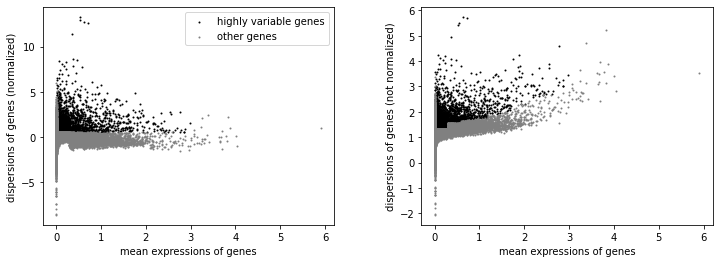

In [26]:
sc.pl.highly_variable_genes(rna_adata)

Let's check how many genes are identified as highly variable

In [27]:
np.sum(rna_adata.var.highly_variable)

4421

Next we run dimensionality reduction with PCA and use PCs to construct a K-nearest neighbor graph for visualization of our cells in UMAP

In [28]:
sc.pp.pca(rna_adata)
sc.pp.neighbors(rna_adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(rna_adata)

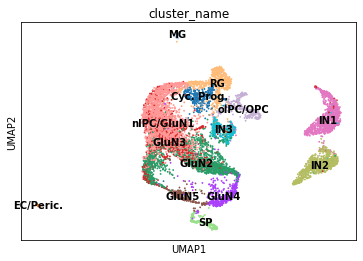

In [30]:
sc.pl.umap(rna_adata, color=["cluster_name"], legend_loc="on data")

We can see differences in expression of known marker genes for neuronal intermediate progenitor cells (nIPC) and different stages of differentiation of glutamatergic excitatory neurons (GluN).

In [101]:
marker_genes = {
    "nIPC":['EOMES', 'PPP1R17', 'PENK', 'NEUROG1', 'NEUROG2'],
    "GluN":['NEUROD2', 'TBR1', 'BCL11B', 'SATB2', 'SLC17A7']
               }

/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/anndata/_core/anndata.py:891: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['AL627309.1', 'AL627309.5', 'AL669831.2', 'AL669831.5', 'FAM87B']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


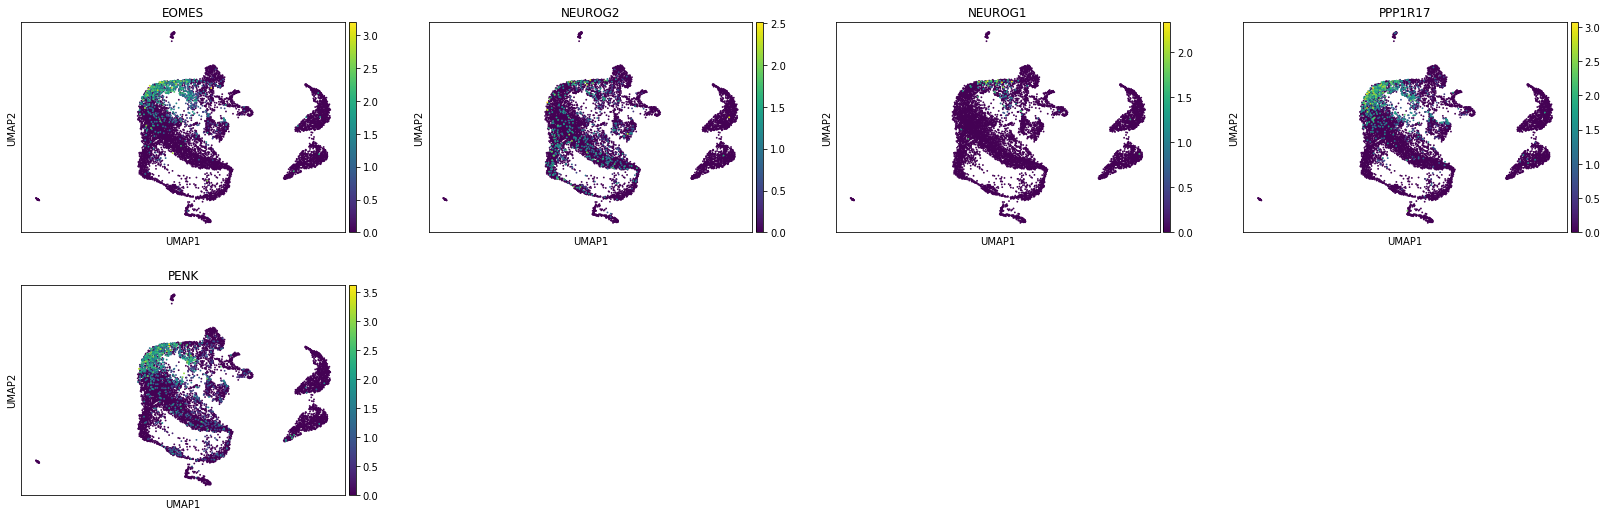

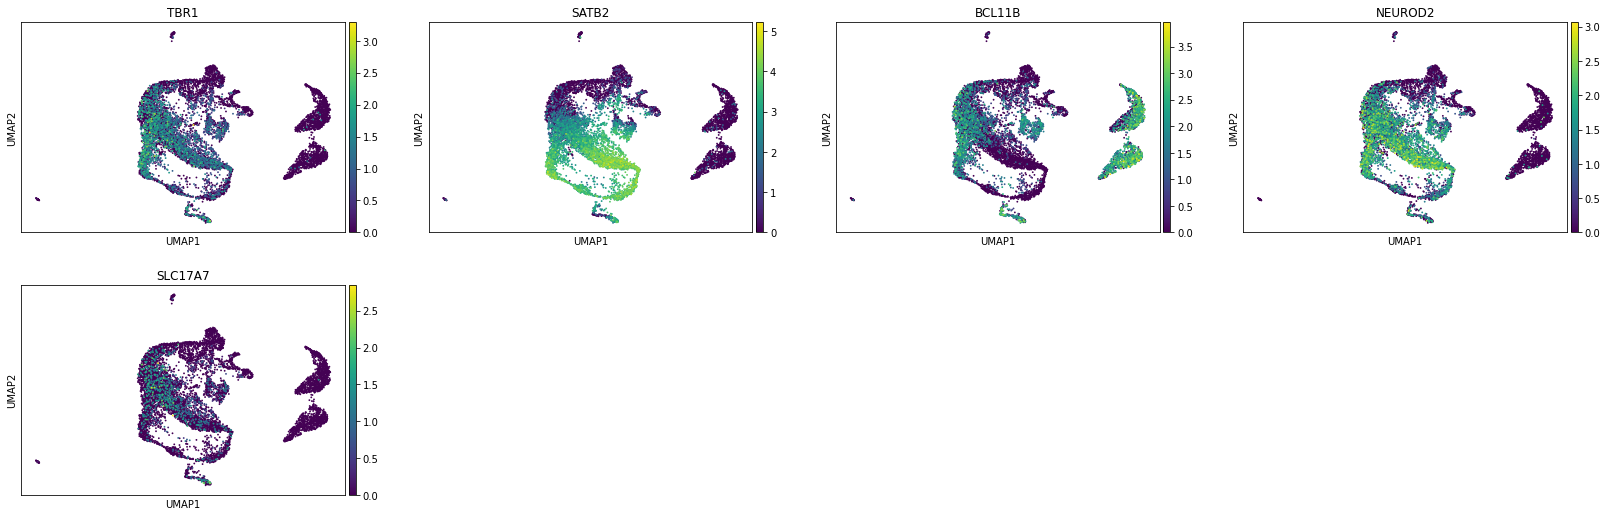

In [31]:
rna_adata.var_names = rna_adata.var["gene_name"].values.copy()
sc.pl.umap(rna_adata, color=rna_adata.var_names[rna_adata.var_names.isin(marker_genes["nIPC"])])
sc.pl.umap(rna_adata, color=rna_adata.var_names[rna_adata.var_names.isin(marker_genes["GluN"])])

We can use ordinary [diffusion pseudotime](https://www.nature.com/articles/nmeth.3971) to order excitatory neurons along a differentiation trajectory stemming from the nIPCs. 

In [35]:
## Subset to glutamatergic neurons
ext_rna_adata = rna_adata[rna_adata.obs["in_GluN_trajectory"]].copy()
sc.pp.pca(ext_rna_adata)
sc.pp.neighbors(ext_rna_adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(ext_rna_adata)

/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


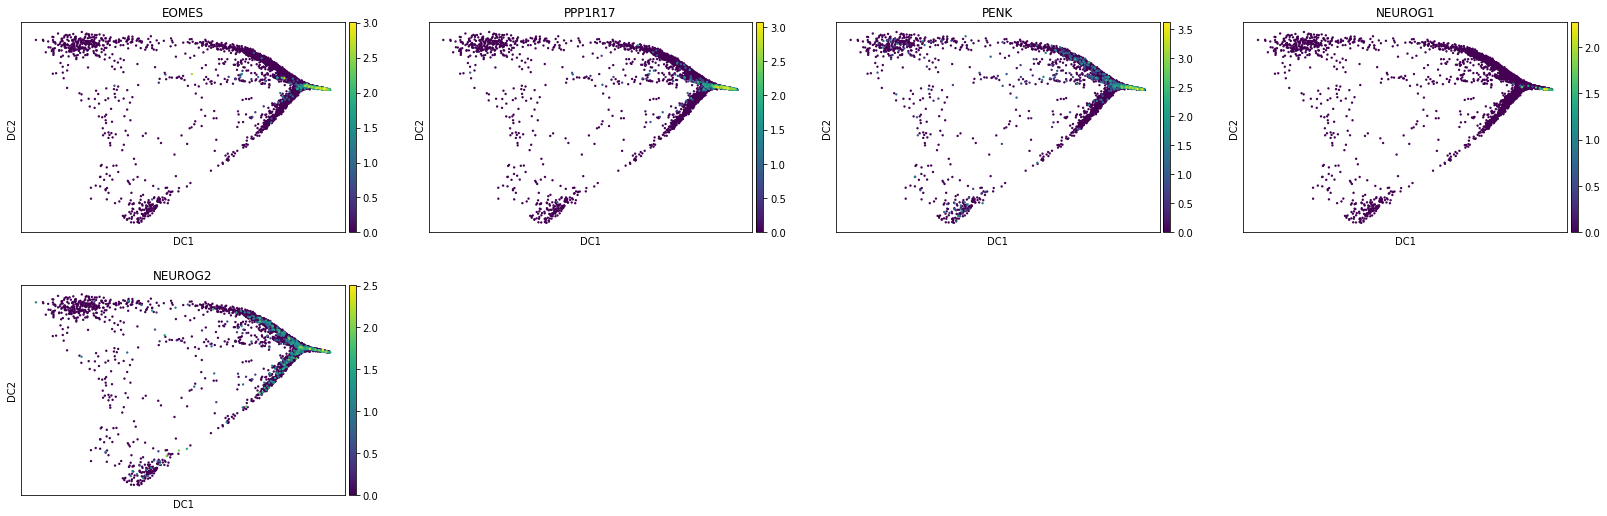

In [36]:
sc.tl.diffmap(ext_rna_adata)
sc.pl.diffmap(ext_rna_adata, color=marker_genes['nIPC'])

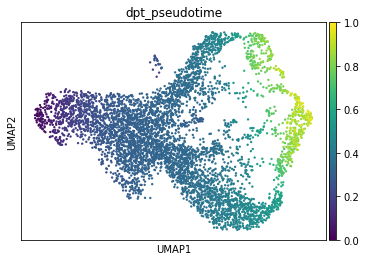

In [37]:
## Define the putative root cell (start of differentiation trajectory)
## we take the maximum for DC1 as the root nIPC
ext_rna_adata.uns['iroot'] = ext_rna_adata.obsm["X_diffmap"][:,1].argmax() 
sc.tl.dpt(ext_rna_adata)
sc.pl.umap(ext_rna_adata, color=["dpt_pseudotime"])

We can already observe different patterns of expression along pseudotime for the GluN marker genes

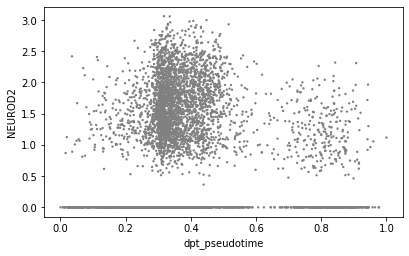

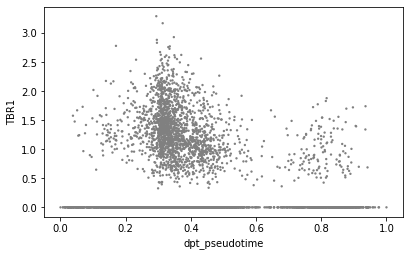

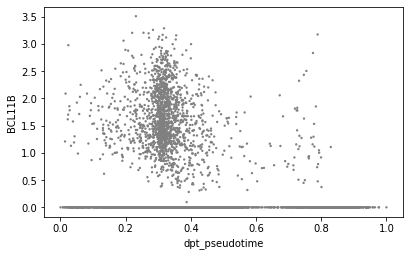

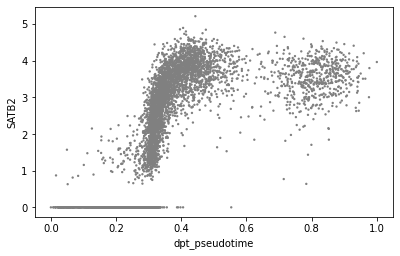

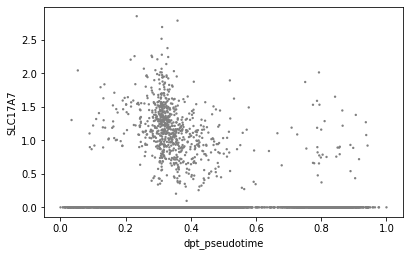

In [38]:
for g in marker_genes["GluN"]:
    sc.pl.scatter(ext_rna_adata, 'dpt_pseudotime', g)

---

## Preprocessing ATAC modality

We are going to use the functions for preprocessing of scATAC data in python implemented in `muon`

In [39]:
from muon import atac as ac

Again, here QC metrics such as the signal at Transcriptional Start Sites and cell and gene filtering were already calculated and used for filtering cells (see implementation in [muon.atac](https://muon.readthedocs.io/en/latest/omics/atac.html)).

Since scATAC data is extremely sparse and most non-zero values in it are 1 and 2, it's common practice to binarize the data matrix.

In [40]:
ac.pp.binarize(atac_adata)

We filter out peaks that are accessible in less than 10 cells 

In [41]:
sc.pp.filter_genes(atac_adata, min_cells=10)

In [42]:
atac_adata

AnnData object with n_obs × n_vars = 8981 × 444692
    obs: 'Sample.ID', 'Sample.Age', 'Sample.Batch', 'Cell.Barcode', 'RNA.Counts', 'RNA.Features', 'Dissociation.ID', 'percentMT', 'percentRibo', 'CR_Estimated.number.of.cells', 'clusterID', 'cluster_name', 'cluster_name_long', 'Assay', 'in_GluN_trajectory'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'name', 'n_cells'

Now we want to perform dimensionality reduction to visualize our scATAC cells with UMAP. Notably, the stardard PCA on log-normalized used for scRNA-seq data isn't suitable for ATAC data, mainly because there is no good way of selecting "highly variable features" in a binary (or quasi-binary) matrix. Here we will use a simple dimensionality reduction approach called Latent Semantic Indexing (or alternatively Latent Semantic Analysis). Please note that there are several alternative methods/models for dimensionality reduction of scATAC data (e.g. [cisTopic](https://www.nature.com/articles/s41592-019-0367-1), [peakVI](https://www.biorxiv.org/content/10.1101/2021.04.29.442020v1.full), [scOpen](https://www.biorxiv.org/content/10.1101/865931v3)). These are more computationally-intensive, but often show more robust performance than LSI, especially when the data is not exactly squeaky-clean.

With LSI, we normalize the data to minimize the differences driven by total coverage from each cell using a procedure named Term Frequency - Inverse Document Frequency (or TF-IDF). This is a normalization technique adapted from text processing, were we consider each peak as a "term" in a "document" (the cell). This is typically followed by singular value decomposition (SVD) — the same technique that convential principal component analysis (PCA) uses — to generate latent dimensions. The combination of TF-IDF and SVD is referred to as Latent Semantic Indexing (LSI).

TF-IDF normalization is implemented in `muon.atac`.

In [43]:
ac.pp.tfidf(atac_adata, scale_factor=1e4)

In [44]:
## For the PCA step, we can use the standard scanpy function or ac.pp.lsi
# (this can take a while, many features!)
sc.pp.pca(atac_adata)

A word of caution on LSI: typically we see that the first latent factor or the first few latent factors found with this procedure are very strongly correlated with the total counts in the cells. Some workflows suggest excluding these latent factors that simply capture the coverage. In practice, it's not straight-forward to decide which latent factors whould be kept and which should be excluded, so for now we keep them all.

In [45]:
atac_adata.obsm["X_lsi"] = atac_adata.obsm["X_pca"].copy()
atac_adata.obs["LSI_f1"] = atac_adata.obsm["X_lsi"][:,0]
atac_adata.obs["LSI_f2"] = atac_adata.obsm["X_lsi"][:,1]

In [47]:
sc.pp.calculate_qc_metrics(atac_adata, percent_top=None, log1p=False, inplace=True)

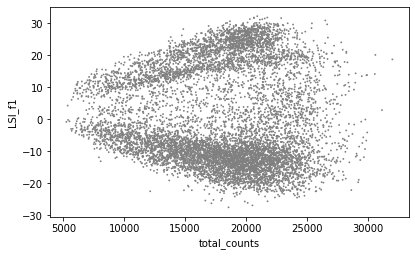

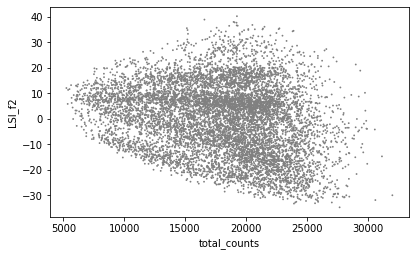

In [48]:
sc.pl.scatter(atac_adata, "total_counts", "LSI_f1")
sc.pl.scatter(atac_adata, "total_counts", "LSI_f2")

We can now compute a KNN graph for clustering and UMAP

In [49]:
sc.pp.neighbors(atac_adata, use_rep="X_lsi", n_neighbors=10, n_pcs=30)
sc.tl.umap(atac_adata)

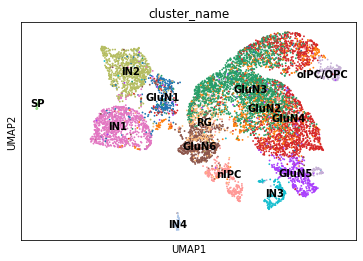

In [50]:
sc.pl.umap(atac_adata, color=["cluster_name"], legend_loc="on data")

Now it's time to start the joint analysis of scRNA and scATAC, where we aim to identify non-coding chromatin regions associated with expression of variable genes during excitatory neuron development.

First off, let's save the progress we've done on the single-modalities in the `.obs` of the multi-omic object container

In [51]:
mdata.update_obs()

In [52]:
# output_dir = /path/to/outdir/
mdata.write("{d}/vertical_clean.h5mu".format(d=output_dir))

In [129]:
mdata = mu.read("{d}/vertical_clean.h5mu".format(d=output_dir))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Step 1: Co-embedding to define a pseudotime ordering of the differentiating excitatory neurons from the nIPCs

In principle, you could just generate a latent embedding and pseudotime ordering on the scRNA modality, and take that as a representative embedding of your cells. However, it might be beneficial to incorporate information from both modalities in the embedding, using what we defined as "vertical integration" strategies. We recommend trying:

- Multi-omics factors analysis: ([paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02015-1)) 
    - Train model in R ([R package](https://github.com/bioFAM/MOFA2)) ([vignette](https://raw.githack.com/bioFAM/MOFA2_tutorials/master/R_tutorials/10x_scRNA_scATAC.html))
    - Train model in python ([vignette](https://github.com/bioFAM/mofapy2/blob/master/mofapy2/notebooks/getting_started_python.ipynb)) - be aware that you can substitute the `ent.set_data_options` step with `mu.tl._set_mofa_data_from_mudata`, to use directly on MuData objects. Muon also has a MOFA wrapper in `mu.tl.mofa`.
- Seurat V4 Weighted Nearest Neighbor analysis ([paper](https://www.cell.com/cell/fulltext/S0092-8674%2821%2900583-3))
    - Run in R ([vignette](https://satijalab.org/seurat/v4.0/weighted_nearest_neighbor_analysis.html)) - you can refer to the [interoperability notebook](https://github.com/NBISweden/single-cell_sib_scilifelab_2021/blob/main/project_omics/rpy2_interoperability_examples.ipynb) to create a Seurat object and run R code within this notebook 
    - Run in python with [muon wrapper](https://muon.readthedocs.io/en/latest/omics/multi.html#weighted-nearest-neighbours)

<!-- Of note, both of these are re-implemented for MuData objects in `muon` (see [here](https://muon.readthedocs.io/en/latest/omics/multi.html)).  -->
<!-- If you prefer using the native R implementations you can refer to the [python/R interoperability notebook]() to use R code within this notebook.  -->

Other interesting approaches: j-UMAP ([code](https://github.com/canzarlab/JVis-learn)), Schema ([paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02313-2)) ([code](https://schema-multimodal.readthedocs.io/en/latest/overview.html)).

It will be interesting to assess what you gain from the joint embedding, in comparison to just using the RNA. It's worth noting that while the differences might be very subtle in the case of RNA-ATAC integration, it has been shown that there is a tangible gain in clustering resolution using these vertical integration strategies on other modalities such as RNA-protein (CITE-seq data).

An additional consideration: should you subset the data to the GluN trajectory before or after co-embedding?

### Running MOFA

In [15]:
## Select highly variable peaks from TF-IDF normalized profiles (not ideal)
sc.pp.highly_variable_genes(mdata["atac"], 
                           min_mean=0, max_mean=3, min_disp=0.1,
                           n_top_genes=5000)

In [16]:
## Subset the muon object directly
mdata.mod["rna"] = mdata.mod["rna"][:,mdata.mod["rna"].var["highly_variable"]].copy()
mdata.mod["atac"] = mdata.mod["atac"][:,mdata.mod["atac"].var["highly_variable"]].copy()

# mdata.mod["atac"] = mdata["atac"][mdata["atac"].obs["in_GluN_trajectory"]].copy()
# mdata.mod["rna"] = mdata["rna"][mdata["rna"].obs["in_GluN_trajectory"]].copy()

mdata.update()

In [17]:
## Run mofapy2
from mofapy2.run.entry_point import entry_point

# initialise the entry point
ent = entry_point()

lik = ['gaussian', 'gaussian']

ent.set_data_options(scale_views=True, scale_groups=False)
mu.tl._set_mofa_data_from_mudata(
        model=ent,
        mdata=mdata,
        likelihoods=lik
)

ent.set_model_options(factors=30)
ent.set_train_options()
ent.build()
ent.run()
ent.save("./vertical.mofa_trained.h5ad")


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Scaling views to unit variance...

Loaded view='atac' group='group1' with N=8981 samples and D=5000 features...
Loaded view='rna' group='group1' with N=8981 samples and D=4421 features...


Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Sp

In [130]:
import h5py
ent = h5py.File('./vertical.mofa_trained.h5ad', 'r')

When we examine variance explained by the factors in each modality, we can see that factors are mostly driven by the RNA data

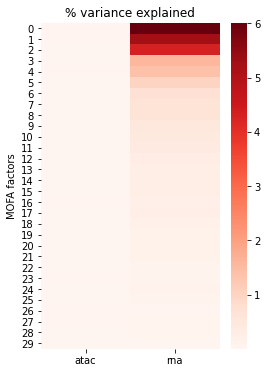

In [41]:
import seaborn as sns
X_mofa = np.array(ent["expectations"]["Z"]["group1"])

plt.rcParams["figure.figsize"] = [4,6]
modalities = list(ent["data"].keys())
r2_matrix = pd.DataFrame(np.array(ent["variance_explained"]["r2_per_factor"]["group1"]).T, columns=modalities)
sns.heatmap(r2_matrix, cmap="Reds");
plt.ylabel("MOFA factors");
plt.title("% variance explained");

In [131]:
## Add MOFA embedding to the muon object
mdata.obsm['X_mofa'] = X_mofa.T

In [132]:
## Calculate KNN graph and UMAP from the MOFA latent factors
# (remember to use scanpy.pp.neighbors, not muon.pp.neighbors)
mdata.uns = {}
sc.pp.neighbors(mdata, use_rep="X_mofa", key_added="mofa")
sc.tl.umap(mdata, neighbors_key="mofa")

In [133]:
mdata.obsm["X_umap_mofa"] = mdata.obsm["X_umap"].copy() 

### WNN embedding

In [64]:
mdata.update()
# mdata.uns = {} ## try this if mu.pp.neighbors throws error
mu.pp.neighbors(mdata)
mu.tl.umap(mdata)

/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "generate_leaf_updates" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "init_rp_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/pynndescent/pynndescent_.py:341: NumbaWarning: Cannot cache compiled function "init_random" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_random(n_neighbors, data, current_graph, dist, rng_state)
/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/pynndescent/pynnd

In [65]:
mdata.obsm["X_umap_WNN"] = mdata.obsm["X_umap"].copy() 

In [136]:
mdata.write("./vertical_clean_embeddings.h5mu".format(d=output_dir))

In [12]:
output_dir = './outputs/'

In [9]:
import os
os.listdir(output_dir)

['motif_matches_multiome.RDS',
 'motif_matches.RDS',
 'ATAC_SCE.RDS',
 'signif_pairs_matched.csv',
 'vertical.mofa_trained.h5ad',
 'aggregated_ATAC_SCE.RDS',
 'peak2genes_tested_pairs.csv',
 'vertical_clean_embeddings.h5mu',
 'background_peaks_unmatched.RDS',
 'RNA_seurat.RDS',
 'background_peaks_multiome.RDS',
 'aggregated_RNA_SCE.RDS',
 'motif_deviations.RDS']

In [167]:
mdata = mu.read("{d}/vertical_clean_embeddings.h5mu".format(d=output_dir))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Compare embeddings 

/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'atac:name' as categorical
/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'rna:gene_id' as categorical
/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_c

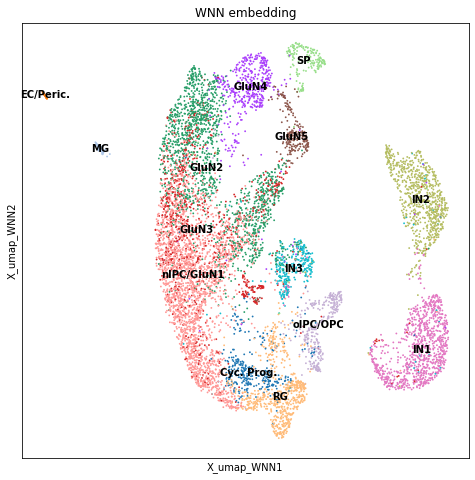

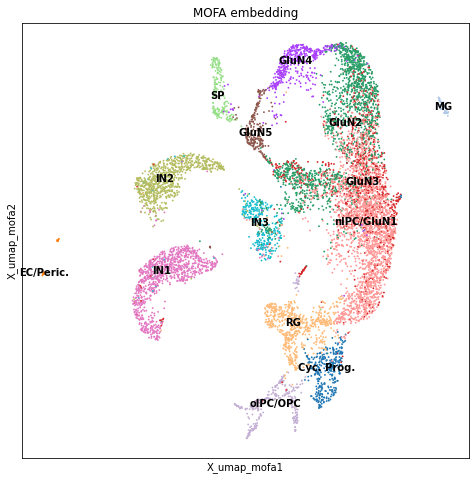

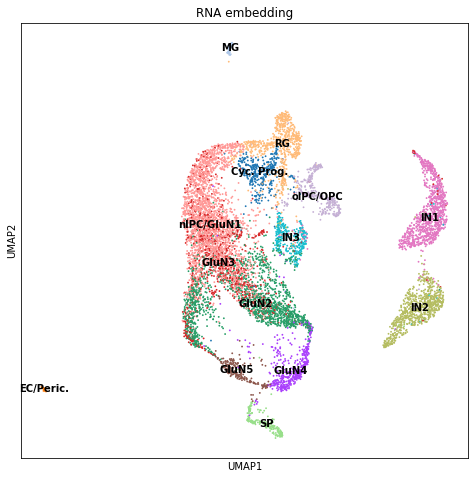

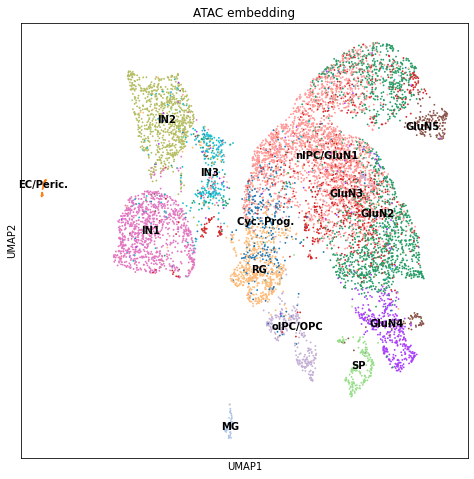

In [69]:
plt.rcParams["figure.figsize"] = [8,8]
sc.pl.embedding(mdata, basis="X_umap_WNN", color="rna:cluster_name", 
                legend_loc="on data", title="WNN embedding")
sc.pl.embedding(mdata, basis="X_umap_mofa", color="rna:cluster_name", 
                legend_loc="on data", title="MOFA embedding")
sc.pl.umap(mdata.mod['rna'], color="cluster_name", 
                legend_loc="on data", title="RNA embedding")

mdata.mod['atac'].obs['rna_cluster_name'] = mdata.obs['rna:cluster_name']
sc.pl.umap(mdata.mod['atac'], color="rna_cluster_name", 
                legend_loc="on data", title="ATAC embedding")

A notable difference in these embeddings is in the separation of the Cycling Progenitor cells, which we don't expect to be distinct in chromatin accessibility profiles. Their different placement in WNN and MOFA hints towards the fact that the MOFA embedding is skewed towards the RNA modality. 

Correlating the MOFA factors with the reduced dimensions from single-omic modality, we see that the first 5-10 factors almost entirely match the RNA PCs.

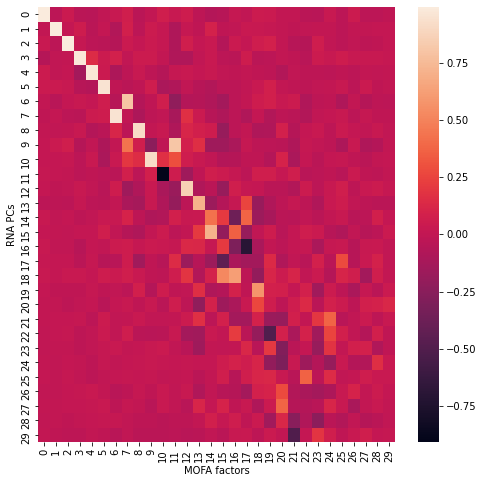

In [87]:
cormat = np.corrcoef(mdata.obsm["X_mofa"][:,0:30].T, mdata["rna"].obsm["X_pca"][:,0:30].T)
sns.heatmap(cormat[30:,0:30]);
plt.xlabel("MOFA factors");
plt.ylabel("RNA PCs");

While the comparison with ATAC LSI factors is less clear cut

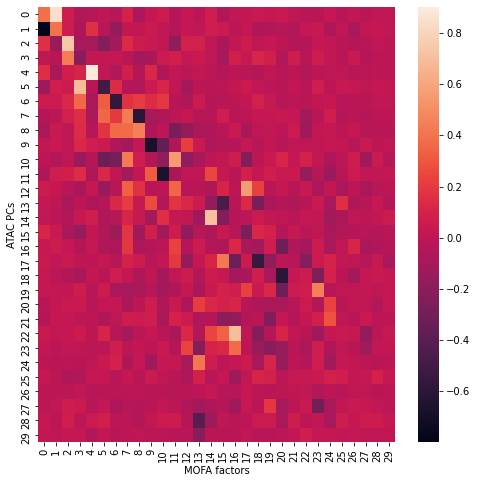

In [91]:
cormat = np.corrcoef(mdata.obsm["X_mofa"][:,0:30].T, mdata["atac"].obsm["X_lsi"][:,0:30].T)
sns.heatmap(cormat[30:,0:30]);
plt.xlabel("MOFA factors");
plt.ylabel("ATAC PCs");

Let's compare diffusion pseudotime trajectories: we define the root cell based on RNA embedding

In [72]:
## filter to gluN trajectory 
# (note that clusters are not exactly the same between modalities,
# so pick either annotation in RNA or in ATAC)
mdata = mdata[mdata['rna'].obs['in_GluN_trajectory']].copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [73]:
sc.pp.pca(mdata.mod['rna'])
sc.pp.neighbors(mdata.mod['rna'], n_neighbors=10, n_pcs=30)
sc.tl.diffmap(mdata['rna'])

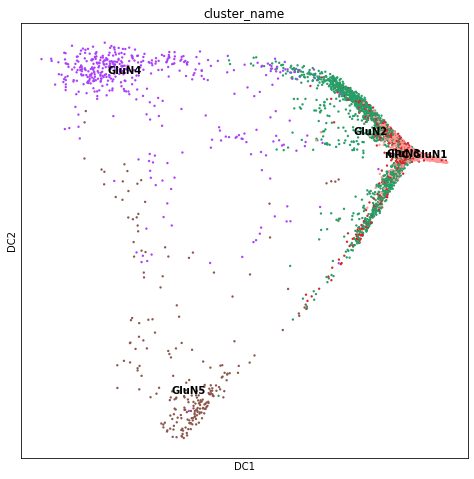

In [74]:
sc.pl.diffmap(mdata['rna'], color='cluster_name', legend_loc="on data")

In [76]:
## Define the putative root cell (start of differentiation trajectory)
## we take the maximum for DC1 as the root nIPC
mdata['rna'].uns['iroot'] = mdata['rna'].obsm["X_diffmap"][:,1].argmax() 
mdata.uns['iroot'] = mdata['rna'].obsm["X_diffmap"][:,1].argmax() 

sc.tl.dpt(mdata['rna'])
mdata.obs["dpt_pseudotime_rna"] = mdata['rna'].obs.dpt_pseudotime

In [79]:
## DPT on MOFA 
sc.pp.neighbors(mdata, use_rep="X_mofa", key_added="mofa")
sc.tl.diffmap(mdata, neighbors_key='mofa')
sc.tl.dpt(mdata, neighbors_key="mofa")
mdata.obs["dpt_pseudotime_MOFA"] = mdata.obs.dpt_pseudotime

In [81]:
## DPT on WNN
# recompute on subset
sc.pp.neighbors(mdata["rna"], use_rep="X_pca", n_neighbors=10, n_pcs=30)
sc.pp.neighbors(mdata["atac"], use_rep="X_lsi", n_neighbors=10, n_pcs=30)
mu.pp.neighbors(mdata) 

/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "generate_leaf_updates" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "init_rp_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/pynndescent/pynndescent_.py:341: NumbaWarning: Cannot cache compiled function "init_random" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_random(n_neighbors, data, current_graph, dist, rng_state)
/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/pynndescent/pynnd

In [83]:
sc.tl.diffmap(mdata)
sc.tl.dpt(mdata)
mdata.obs["dpt_pseudotime_WNN"] = mdata.obs.dpt_pseudotime

We can compare the pseudotime ordering from the different embeddings

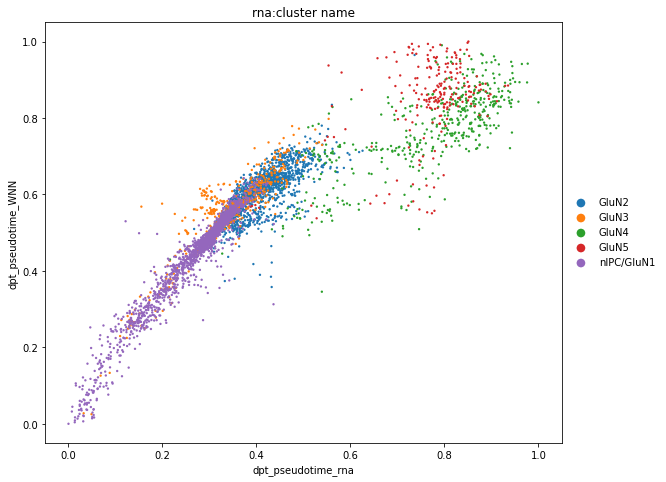

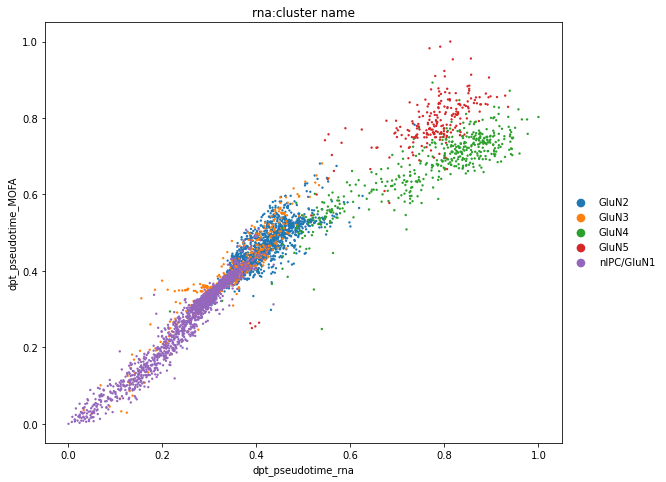

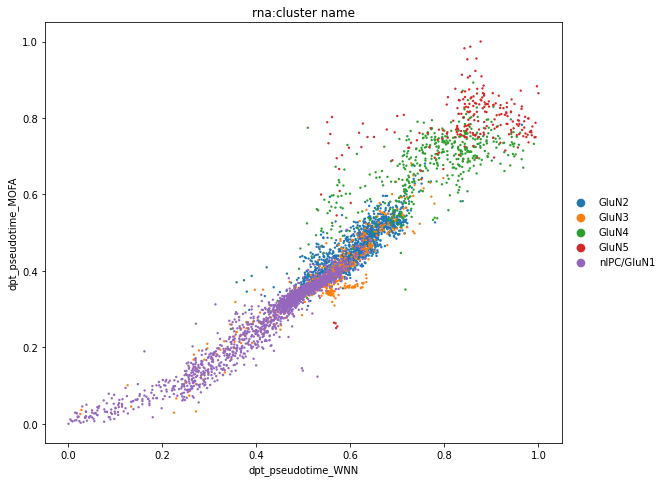

In [87]:
sc.pl.scatter(mdata, 'dpt_pseudotime_rna', 'dpt_pseudotime_WNN', color="rna:cluster_name")
sc.pl.scatter(mdata, 'dpt_pseudotime_rna', 'dpt_pseudotime_MOFA', color="rna:cluster_name")
sc.pl.scatter(mdata, 'dpt_pseudotime_WNN', 'dpt_pseudotime_MOFA', color="rna:cluster_name")

The multi-omic embeddings seem to distinguish better cluster GluN5 and GluN4 in pseudotime ordering.

In [90]:
mdata.var_names_make_unique()

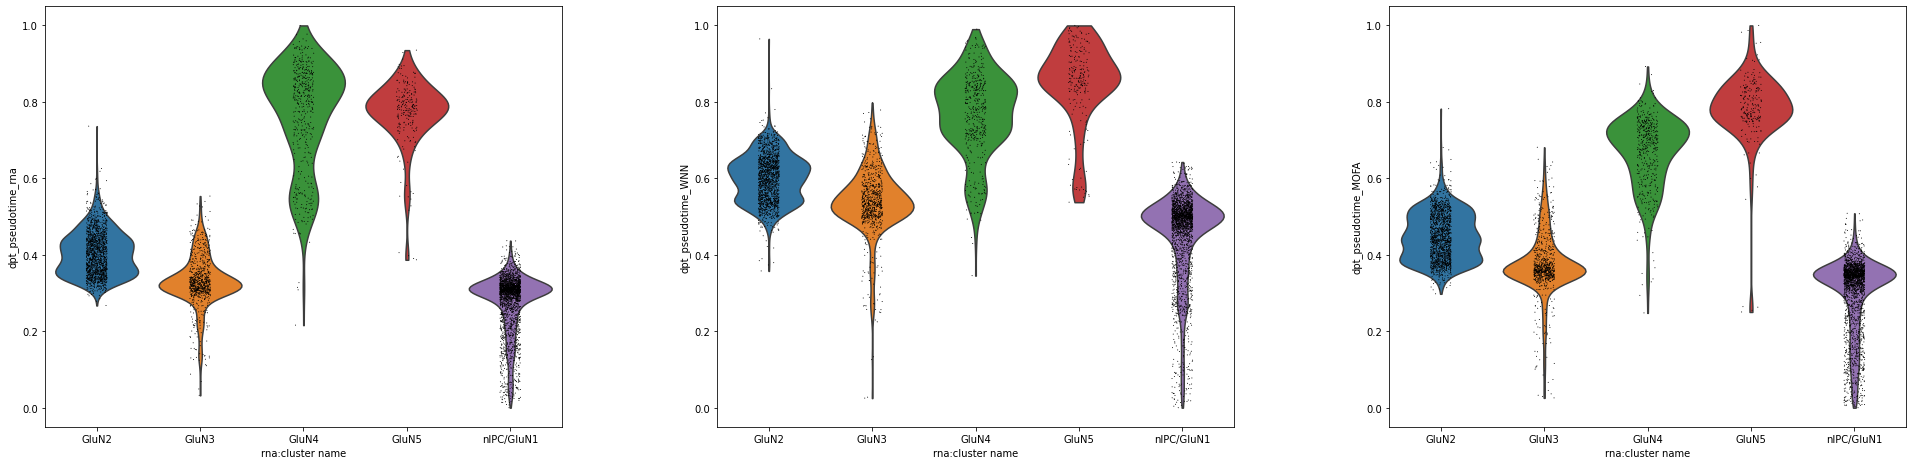

In [93]:
sc.pl.violin(mdata, ["dpt_pseudotime_rna", "dpt_pseudotime_WNN", "dpt_pseudotime_MOFA"], groupby="rna:cluster_name")

---

## Step 2: Selecting features for chromatin-expression associations

Now that you have a common embedding and hopefully a common pseudotime axis, we need to select the features that we will use to associate gene expression to chromatin accessibility. We could be greedy and try to test all the possible combinations of genes and peaks, but this would likely be prohibitively computationally expensive (with > 30K genes and > 400k peaks!), not to mention the multiple testing burden we would have. In addition, we know that long range interactions on the genome are possible, but they are not very common, so it doesn't make too much sense to test for associations between genes and chromatin regions that are extremely far apart e.g. on different chromosomes. 

**Feature selection for gene expression:** select a subset of interesting genes that seem to have a dynamic behaviour in the differentiation trajectory. You could select these with standard strategies for variable gene selection (in [R](https://bioconductor.org/books/release/OSCA/feature-selection.html), in [python](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html)), or you could correlate the log-normalized gene expression to the value of pseudotime, to select genes that increase or decrease in expression during differentiation. 

For better approaches to find variable genes in pseudotime, see [tradeSeq](https://bioconductor.org/packages/release/bioc/html/tradeSeq.html) or [cellrank](https://cellrank.readthedocs.io/en/stable/auto_examples/other/plot_model.html#sphx-glr-auto-examples-other-plot-model-py).

**Feature selection for chromatin accessibility:** you'll need to decide _what type of features_ and _which features_ to use at the chromatin level:

- what type of feature: you could use all the peak identified by peak calling, or aggregate counts in peaks that contain the same transcription factor binding motifs (e.g. using [ChromVAR](https://github.com/GreenleafLab/chromVAR)), aggregate counts over peaks in larger genomic windows, collapse counts from co-accessible peaks identified using [Cicero](https://cole-trapnell-lab.github.io/cicero-release/docs_m3/#installing-cicero), any other ideas...?
- which chromatin features should be tested against which genes? Especially if you pick features defined by genomic positions, it's best to subset the possible gene-region pairs to regions within a certain range of the gene. A window of 100k base pairs is often used. See below for an example implementation (in R) to associate genes to peaks in their proximity, using the functionality from [`GenomicRanges`](https://bioconductor.org/packages/release/bioc/vignettes/GenomicRanges/inst/doc/GenomicRangesIntroduction.html).


In [16]:
%%R
library(tidyr)
## Helper functions 

## String - GRanges conversion
## Borrowed from Signac functions 
## https://satijalab.org/signac/reference/GRangesToString.html
StringToGRanges <- function(regions, sep = c("-", "-"), ...) {
  ranges.df <- data.frame(ranges = regions)
  ranges.df <- separate(
    data = ranges.df,
    col = "ranges",
    sep = paste0(sep[[1]], "|", sep[[2]]),
    into = c("chr", "start", "end")
  )
  granges <- makeGRangesFromDataFrame(df = ranges.df, ...)
  return(granges)
}

GRangesToString <- function(grange, sep = c("-", "-")) {
  regions <- paste0(
    as.character(x = seqnames(x = grange)),
    sep[[1]],
    start(x = grange),
    sep[[2]],
    end(x = grange)
  )
  return(regions)
}

# Extend genomicRanges
# 
extend <- function(x, upstream=0, downstream=0)     
{
    if (any(strand(x) == "*"))
        warning("'*' ranges were treated as '+'")
    on_plus <- strand(x) == "+" | strand(x) == "*"
    new_start <- start(x) - ifelse(on_plus, upstream, downstream)
    new_end <- end(x) + ifelse(on_plus, downstream, upstream)
    ranges(x) <- IRanges(new_start, new_end)
    trim(x)
}

# Find peaks close to features of interest
#
# @param peaks_gr GenomicRanges object containing genomic locations of peaks
# @param features_gr GenomicRanges object containing genomic locations of features (e.g. genes)
# @param d distance to include peak, in bps (default 50000)
# @param feat_anno column in `features_gr@elementMetadata` containing annotation to name features (if NULL converts Granges to string)
#
# @return Sparse adjacency matrix matching peaks to proximal features (peaks in rows, features in columns)
peak2feature <- function(peaks_gr, features_gr, d=50000, feat_anno=NULL){
  seqlevelsStyle(features_gr) <- seqlevelsStyle(peaks_gr)
  
  ## Find peaks overlapping the search range around the features
  ext_gr <- extend(features_gr, upstream = d, downstream = d)
  ovs <- findOverlaps(peaks_gr, ext_gr)
  
  ## Define identifiers for peaks and features
  all_peaks <- GRangesToString(peaks_gr, sep = c(":", '-'))
  if (is.null(feat_anno)) {
    all_feats <- GRangesToString(features_gr, sep = c(":", '-'))
  } else {
    all_feats <- features_gr@elementMetadata[[feat_anno]]
  }
  
  ## Build adjacency matrix for hits
  adj_mat <- Matrix::Matrix(data=0, nrow = length(all_peaks), ncol=length(all_feats))
  for (i in unique(subjectHits(ovs))) {
    adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i] <- 1
  }
  colnames(adj_mat) <- all_feats
  rownames(adj_mat) <- all_peaks
  
  adj_mat
}

R[write to console]: 
Attaching package: ‘tidyr’


R[write to console]: The following object is masked from ‘package:S4Vectors’:

    expand




Remember that the peak positions are stored in `mdata.mod["atac"].var` while you can extract genomic locations of the gene bodies using the R package [`ensembldb`](https://bioconductor.org/packages/release/bioc/vignettes/ensembldb/inst/doc/ensembldb.html#4_Retrieving_sequences_for_genetranscriptexon_models)

In [ ]:
## ...
## Your feature selection / peak-gene pairing code goes here
## ...

#### Select variable genes in pseudotime

In [97]:
from scipy.stats import pearsonr
X_logcounts = mdata['rna'].X.T
keep_genes = np.where(mdata['rna'].var["highly_variable"])[0] 
X_logcounts = X_logcounts[keep_genes,:] 
mdata['rna'].var["dpt_corr_r2"] = np.nan
mdata['rna'].var["dpt_corr_r2"] = np.nan
for i in range(X_logcounts.shape[0]):
    r2,pval = pearsonr(mdata.obs.loc[mdata["rna"].obs_names,"dpt_pseudotime_MOFA"],X_logcounts[i,:].toarray().flatten())
    mdata['rna'].var.loc[mdata["rna"].var_names[keep_genes[i]],"dpt_corr_r2"] = r2
    mdata['rna'].var.loc[mdata["rna"].var_names[keep_genes[i]],"dpt_corr_pval"] = pval

## Adjust for multiple testing
from statsmodels.stats import multitest
_,adj_pvals,_,_ = multitest.multipletests(mdata['rna'].var["dpt_corr_pval"].dropna(), method="fdr_bh")

mdata['rna'].var["dpt_corr_adj_pval"] = np.nan
mdata['rna'].var.loc[~mdata['rna'].var["dpt_corr_pval"].isna(), "dpt_corr_adj_pval"] = adj_pvals

mdata['rna'].var["dpt_corr_neg_log10_pval"] = -np.log10(mdata['rna'].var["dpt_corr_adj_pval"])

In [98]:
## We define as associated to pseudotime genes with absolute correlation > 0.2
mdata['rna'].var["dpt_associated_gene"] = abs(mdata['rna'].var["dpt_corr_r2"]) > 0.2

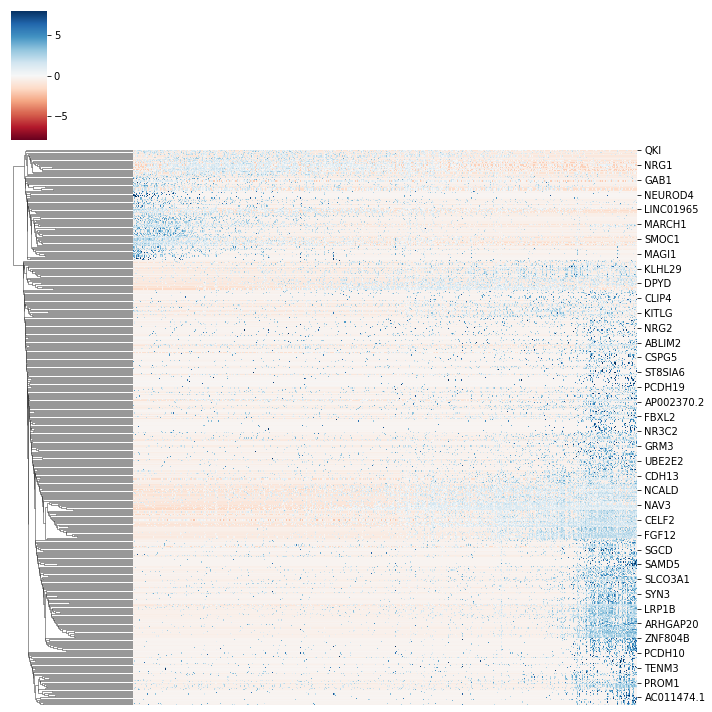

In [99]:
## Extract expression matrix with genes ordered by pseudotime
dpt_order_gex_matrix = mdata["rna"][mdata.obs.loc[mdata["rna"].obs_names,"dpt_pseudotime_MOFA"].argsort(),mdata['rna'].var["dpt_associated_gene"]].X.toarray()
dpt_order_gex_matrix = sc.pp.scale(dpt_order_gex_matrix)
dpt_order_gex_matrix = pd.DataFrame(dpt_order_gex_matrix.T)
dpt_order_gex_matrix.index = mdata['rna'].var_names[mdata['rna'].var["dpt_associated_gene"]]

import seaborn as sns
plt.rcParams["figure.figsize"] = [10,10]
sns.clustermap(dpt_order_gex_matrix, xticklabels=False, col_cluster=False, cmap="RdBu",
              vmin=-8, vmax=8)

In [103]:
## Do we find the known marker genes?
[x in mdata['rna'].var_names[mdata['rna'].var["dpt_associated_gene"]] for x in marker_genes["nIPC"] + marker_genes["GluN"]]

[True, True, True, False, False, False, False, False, True, False]

#### Find the peaks around selected genes

In [121]:
## Get peak ranges
peak_ranges_df = mdata.mod["atac"].var[['seqnames','start', 'end', 'width', 'strand', 'name']]

In [123]:
%%R -i peak_ranges_df
head(peak_ranges_df)

  seqnames  start    end width strand       name
0     chr1 180451 180951   501      *  c7_peak_1
1     chr1 181254 181754   501      *  c2_peak_1
2     chr1 191223 191723   501      *  c9_peak_1
3     chr1 630059 630559   501      *  c6_peak_5
4     chr1 633776 634276   501      *  c8_peak_4
5     chr1 778456 778956   501      * c1_peak_4b


In [126]:
%%R
library(GenomicRanges)
peaks_gr <- GRanges(peak_ranges_df)

In [114]:
selected_genes = mdata['rna'].var_names[mdata['rna'].var["dpt_associated_gene"]].values

In [132]:
%%R -i selected_genes

library(ensembldb)
library(EnsDb.Hsapiens.v86)

hg38_genes <- genes(EnsDb.Hsapiens.v86)
selected_genes_ids <- names(hg38_genes)[hg38_genes$gene_name %in% selected_genes]
genes_gr <- hg38_genes[selected_genes_ids]

In [133]:
%%R
head(genes_gr)

GRanges object with 6 ranges and 6 metadata columns:
                  seqnames            ranges strand |         gene_id
                     <Rle>         <IRanges>  <Rle> |     <character>
  ENSG00000196581        1   4654732-4792534      + | ENSG00000196581
  ENSG00000116649        1 11054584-11060024      - | ENSG00000116649
  ENSG00000189337        1 13892792-15118043      + | ENSG00000189337
  ENSG00000117154        1 18107746-18378483      + | ENSG00000117154
  ENSG00000117643        1 25617468-25786207      + | ENSG00000117643
  ENSG00000121904        1 33513999-34165842      - | ENSG00000121904
                    gene_name   gene_biotype seq_coord_system      symbol
                  <character>    <character>      <character> <character>
  ENSG00000196581       AJAP1 protein_coding       chromosome       AJAP1
  ENSG00000116649         SRM protein_coding       chromosome         SRM
  ENSG00000189337        KAZN protein_coding       chromosome        KAZN
  ENSG00000117154

In [137]:
%%R
adj_mat <- peak2feature(peaks_gr, genes_gr, d=20000)

In [138]:
%%R
rownames(adj_mat) <- GRangesToString(peaks_gr)
colnames(adj_mat) <- names(genes_gr)

adj_mat <- adj_mat[rowSums(adj_mat) > 0,]
adj_mat <- as(adj_mat, "dgTMatrix")

## Convert the sparse adjacency matrix
## to a matrix of peak-gene pairings 
pairnames <- cbind(rownames(adj_mat)[adj_mat@i], colnames(adj_mat)[adj_mat@j])


In [141]:
%%R
nrow(pairnames)

[1] 36626


In [142]:
%%R -i output_dir
write.csv(pairnames, paste0(output_dir, "peak2genes_tested_pairs.csv"))

In [13]:
%%R -i output_dir
pairnames <- read.csv(paste0(output_dir, "peak2genes_tested_pairs.csv"))

---

## Step 3: Aggregate expression/accessibility profiles from multiple cells

This step is optional, but highly recommended! In principle, we could test for correlations between gene expression and chromatin accessibility in single-cells (even the the _unmatched assays_ group can impute an accessibility profile for scRNA cells (and viceversa an expression profile for scATAC cells) taking the average profile of nearest neighbors.

However, it's worth thinking about **aggregating profiles from multiple cells**, using clustering or the KNN graph on the common embedding. This is helpful to deal with the high sparsity of the scATAC profiles, to prioritize the most robust associations and to reduce the computational burden of testing for associations. Think of how you could use a common KNN graph for this purpose: You could sample _n_ cells and create pseudobulk profiles from the K-nearest neighbors of those cells (selecting neighbourhoods where there is a sufficient number of cells from both assays in the case of unmatched data). More robust algorithms to sample neighbourhoods on the KNN graph are implemented in [miloR](https://github.com/MarioniLab/miloR) or [MetaCell](https://github.com/tanaylab/metacell). Alternatively, overclustering with the Louvain or Leiden algorithm can be used.


In [5]:
## ...
## Your code for imputation/aggregation goes here
## ...

#### with KNN smoothing and subsampling

In [173]:
## subset 10% of cells from different quantiles of pseudotime ordering
mdata.obs["dpt_bins"] = pd.cut(mdata.obs["dpt_pseudotime_MOFA"], bins=np.linspace(0,1, 50))
mdata.obs["dpt_bins"] = mdata.obs["dpt_bins"].cat.codes
sample_cells = []
for b in np.unique(mdata.obs["dpt_bins"]):
    bin_obs = mdata.obs[mdata.obs["dpt_bins"]==b]
    sample_cells_bin = list(bin_obs.sample(bin_obs.shape[0]//10).index.values)
    sample_cells.extend(sample_cells_bin)

In [175]:
len(sample_cells)

516

Does this sample cover the whole trajectory?

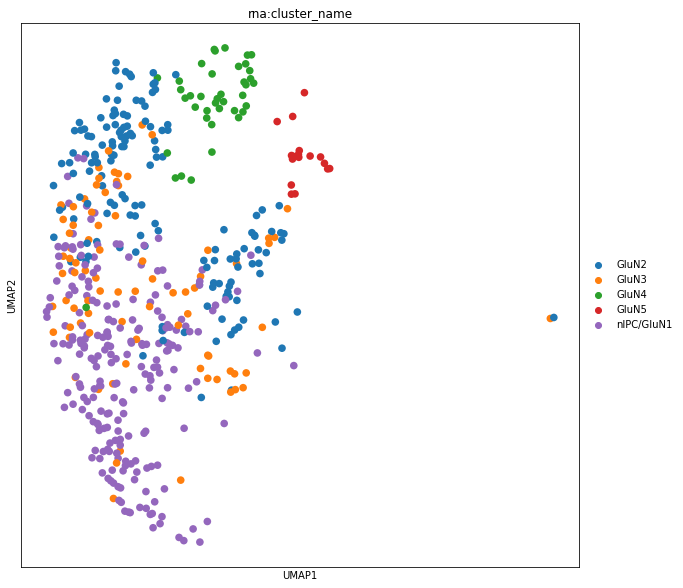

In [241]:
sc.pl.umap(mdata[mdata.obs_names.isin(sample_cells)], color="rna:cluster_name")

In [176]:
connectivities = mdata.obsp["mofa_connectivities"]

In [178]:
connectivities[mdata.obs_names.isin(sample_cells)]

<516x5374 sparse matrix of type '<class 'numpy.float32'>'
	with 11258 stored elements in Compressed Sparse Row format>

In [234]:
# atac2rna_connectivities = connectivities[mdata.obsm["atac"],:][:,mdata.obsm["rna"]]
true_rna =  mdata["rna"].X.copy()
imputed_rna = (
    scipy.sparse.csr_matrix.dot(connectivities.T, true_rna)
    .astype(np.float32)
    .A
)
imputed_rna = imputed_rna / true_rna.sum(1)

In [217]:
# this can eat quite some RAM
true_atac =  mdata["atac"].X.copy()
imputed_atac = (
    scipy.sparse.csr_matrix.dot(connectivities.T, true_atac)
    .astype(np.float32)
    .A
)
imputed_atac = imputed_atac / true_atac.sum(1)

In [237]:
imputed_atac_sample = imputed_atac[mdata.obs_names.isin(sample_cells),:]
imputed_rna_sample = imputed_rna[mdata.obs_names.isin(sample_cells),:]

In [171]:
# ## Make a new MuData object for subset
# imp_rna_adata = anndata.AnnData(X=imputed_rna, obs = mdata["atac"].obs)
# mdata.mod["rna_imputed"] = imp_rna_adata

Check difference for a few peak-gene pairs

In [52]:
pairnames = pd.read_csv('{d}/peak2genes_tested_pairs.csv'.format(d=output_dir), index_col=0)
pairnames.columns = ["peak", "gene"]

In [271]:
def plot_p2g_correlation(X_gex, X_acc):
    plt.plot(X_gex, X_acc, '.');
    plt.xlabel("gene expression");
    plt.ylabel("accessibility");
    
peak_ids = peak_ranges_df.seqnames.astype('str') + "-" + peak_ranges_df.start.astype('str') + "-" + peak_ranges_df.end.astype('str')    

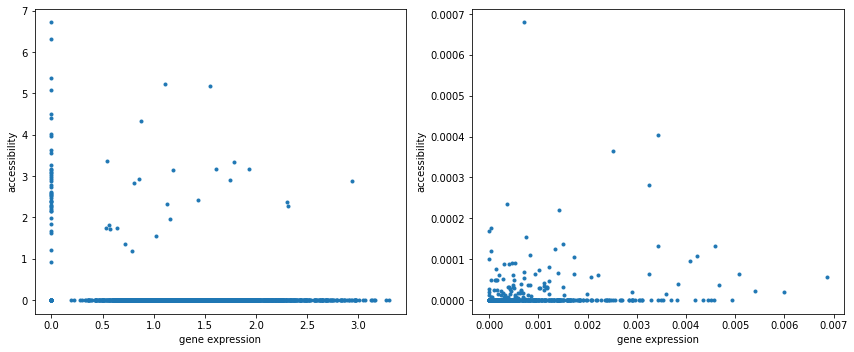

In [293]:
ix = 50
p = pairnames.iloc[ix]['peak']
g = pairnames.iloc[ix]['gene']

X_gex_true = true_rna[:,mdata["rna"].var['gene_ids'] == g].A
X_acc_true = true_atac[:,peak_ids == p].A

X_gex_smooth = imputed_rna_sample[:,mdata["rna"].var['gene_ids'] == g].A
X_acc_smooth = imputed_atac_sample[:,peak_ids == p].A

plt.rcParams["figure.figsize"] = [12,5]
plt.subplot(1,2,1);
plot_p2g_correlation(X_gex_true, X_acc_true);
plt.subplot(1,2,2);
plot_p2g_correlation(X_gex_smooth, X_acc_smooth);
plt.tight_layout()

#### Using Milo to define neighbourhoods 

In [274]:
!pip install git+https://github.com/emdann/milopy.git

  Cloning https://github.com/emdann/milopy.git to /tmp/pip-req-build-4q7dsxmf
  Running command git clone -q https://github.com/emdann/milopy.git /tmp/pip-req-build-4q7dsxmf
  Created wheel for milopy: filename=milopy-0.0.99-py3-none-any.whl size=8816 sha256=ca73f9f4323b779c2679041dd6bf4b7b742a847986444bdd57255fdc87c08f10
  Stored in directory: /tmp/pip-ephem-wheel-cache-u5xeueua/wheels/b9/d6/34/6983c895575551f8a8d12d060977767dd137bf61fde5c07f50
Successfully built milopy


In [276]:
import milopy.core as milo

## Assign cells to neighbourhoods on KNN graph
milo.make_nhoods(mdata, neighbors_key="mofa")

In [278]:
## Get assignment of cells to neighbourhoods
nhood_mat = mdata.obsm['nhoods'].copy()

In [279]:
## Compute average expression/accessibility in neighbourhoods
nhood_mat

<5374x396 sparse matrix of type '<class 'numpy.float32'>'
	with 15211 stored elements in Compressed Sparse Row format>

In [288]:
# atac2rna_connectivities = connectivities[mdata.obsm["atac"],:][:,mdata.obsm["rna"]]
true_rna =  mdata["rna"].X.copy()
nhood_rna = (
    scipy.sparse.csr_matrix.dot(nhood_mat.T, true_rna)
    .astype(np.float32)
    .A
)
nhood_rna = nhood_rna / true_rna.sum(0)
nhood_rna.shape

/tmp/ipykernel_399/3173342604.py:8: RuntimeWarning: invalid value encountered in true_divide
  nhood_rna = nhood_rna / true_rna.sum(0)


(396, 26572)

In [289]:
# this can eat quite some RAM
true_atac =  mdata["atac"].X.copy()
nhood_atac = (
    scipy.sparse.csr_matrix.dot(nhood_mat.T, true_atac)
    .astype(np.float32)
    .A
)
nhood_atac = nhood_atac / true_atac.sum(0)

/tmp/ipykernel_399/2205965685.py:8: RuntimeWarning: invalid value encountered in true_divide
  nhood_atac = nhood_atac / true_atac.sum(0)


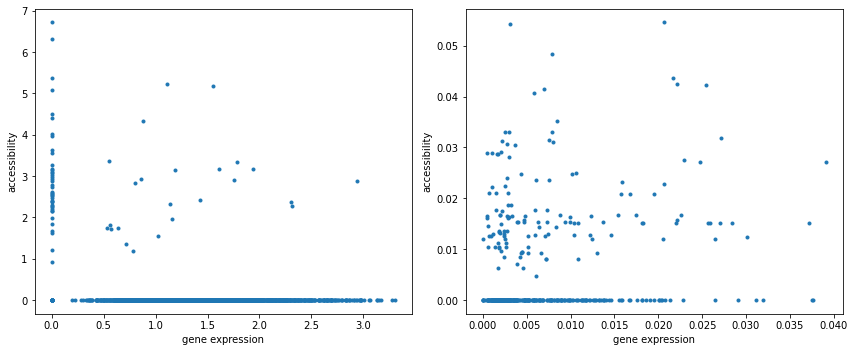

In [300]:
ix = 50
p = pairnames.iloc[ix]['peak']
g = pairnames.iloc[ix]['gene']

X_gex_true = true_rna[:,mdata["rna"].var['gene_ids'] == g].A
X_acc_true = true_atac[:,peak_ids == p].A

X_gex_nhood = nhood_rna[:,mdata["rna"].var['gene_ids'] == g].A
X_acc_nhood = nhood_atac[:,peak_ids == p].A

plt.rcParams["figure.figsize"] = [12,5]
plt.subplot(1,2,1);
plot_p2g_correlation(X_gex_true, X_acc_true);
plt.subplot(1,2,2);
plot_p2g_correlation(X_gex_nhood, X_acc_nhood);
plt.tight_layout()

In [310]:
## Make anndatas for aggregated profiles
agg_atac_adata = anndata.AnnData(imputed_atac_sample)
agg_rna_adata = anndata.AnnData(imputed_rna_sample)

agg_atac_adata.var_names = peak_ids
agg_rna_adata.var_names = mdata['rna'].var["gene_ids"].copy()

---

## Step 4: Associating gene expression to accessibility

To test for correlation between gene expression and chromatin accessibility, a common approach is to compute a gene-peak correlation coefficient (Spearman ⍴ or Pearson R2) by correlating normalized scATAC-seq peak peak counts with the corresponding gene’s expression across all ATAC-RNA paired cells. Then the observed coefficient for each gene-peak pair is compared to the coefficients obtained matching the gene to _n_ "background peaks" with matching total accessibility and GC content to the tested one, accounting for technical biases between cells that are caused by PCR amplification or variable Tn5 tagmentation conditions. This results in a null peak-gene correlation distribution that is independent of peak-gene proximity, that can be used for significance testing (for reference see [Ma et al. 2020](https://www.cell.com/cell/fulltext/S0092-8674(20)31253-8?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867420312538%3Fshowall%3Dtrue), [Kartha et al. 2021](https://www.biorxiv.org/content/10.1101/2021.07.28.453784v1.full)).

The chromVAR package implements simple functions to identify the background peaks:
```R
## In R
library(chromVAR)
library(BSgenome.Hsapiens.UCSC.hg38) ## your reference genome

atac_sce <- readRDS("./processed_data/Multiome_ATAC_ext_trajectory_SCE.RDS")
atac_chromvar_sce <- addGCBias(atac_sce, genome=BSgenome.Hsapiens.UCSC.hg38)
bg <- getBackgroundPeaks(atac_chromvar_sce, niterations = 50) ## This can take a while
```

The ArchR package also provides a [`Peak2GeneLinkage`](https://www.archrproject.com/bookdown/peak2genelinkage-with-archr.html) function to perform a similar mapping (however this only works if you follow their RNA-ATAC integration pipeline from start to finish).

So far out of the ArchR pipeline, there is no well-packaged software tool to test these associations between peaks and genes in single-cell multiomics data. Below we show an example implementation in R, adapting code from [the Buenrostro lab](https://github.com/buenrostrolab/stimATAC_analyses_code).

**Test on a few genes first!** You don't want your code to run for 10 minutes to find out it didn't work at all.


In [42]:
%%R
library(dplyr)

## Function to correlate peak expression to gene accessibility
#
# @param rna_sce a SingleCellExperiment object for RNA modality
# @param atac_sce a SingleCellExperiment object for ATAC modality
# @param pairnames a matrix of dimensions 2 * no. of pairs to test, where h 
# 
# @return updated pairnames matrix with an additional column containing 
# the spearman correlation coefficient for the pair
# 
run_p2gene_cor <- function(rna_sce, atac_sce, pairnames){
  pairnames <- as.data.frame(pairnames)
  uniq_peaks <- unique(pairnames[,1])
  uniq_genes <- unique(pairnames[,2])
  
  A = assay(atac_sce) # ATAC matrix
  R = assay(rna_sce) # RNA matrix
  
  all_peaks <- GRangesToString(rowRanges(atac_sce), sep = c("-", "-"))
  uniq_peaks_ixs <- which(all_peaks %in% uniq_peaks)
  uniq_genes_ixs <- which(rownames(R) %in% uniq_genes)
  
  M1 <- as.matrix(Matrix::t(A[uniq_peaks_ixs,,drop=FALSE])) 
  M2 <- as.matrix(Matrix::t(R[uniq_genes_ixs,,drop=FALSE])) 
  
  cormat <- cor(x = M1, y = M2, method = "spearman")
  rownames(cormat) <- all_peaks[uniq_peaks_ixs]
  colnames(cormat) <- rownames(R)[uniq_genes_ixs]
  cors <- sapply(1:nrow(pairnames), function(i) cormat[pairnames[i,1], pairnames[i,2]])
  pairnames <- cbind(pairnames, cors)
  colnames(pairnames) <- c("peak", "gene", "cor")
  return(pairnames)
}

In [340]:
%%R -i agg_atac_adata
rowRanges(agg_atac_adata) <- StringToGRanges(rownames(agg_atac_adata))
rownames(agg_atac_adata) <- peak_ids
agg_atac_adata

class: SingleCellExperiment 
dim: 444692 516 
metadata(0):
assays(1): X
rownames(444692): chr1-180451-180951 chr1-181254-181754 ...
  chr22-50783378-50783878 chr22-50807894-50808394
rowData names(0):
colnames(516): 0 1 ... 514 515
colData names(0):
reducedDimNames(0):
altExpNames(0):


In [314]:
%%R -i agg_rna_adata
agg_rna_adata

class: SingleCellExperiment 
dim: 26572 516 
metadata(0):
assays(1): X
rownames(26572): ENSG00000238009 ENSG00000241860 ... ENSG00000198695
  ENSG00000198727
rowData names(0):
colnames(516): 0 1 ... 514 515
colData names(0):
reducedDimNames(0):
altExpNames(0):


In [58]:
%%R -i pairnames
pairnames <- pairnames[pairnames[,'gene'] %in% rownames(agg_rna_adata),]
pairnames <- pairnames[pairnames[,'peak'] %in% rownames(agg_atac_adata),]
head(pairnames)

                  peak            gene
1 chr1-4637203-4637703 ENSG00000196581
2 chr1-4650315-4650815 ENSG00000196581
3 chr1-4652491-4652991 ENSG00000196581
4 chr1-4653794-4654294 ENSG00000196581
5 chr1-4654342-4654842 ENSG00000196581
6 chr1-4655017-4655517 ENSG00000196581


In [49]:
%%R
# saveRDS(agg_rna_adata, paste0(output_dir, "aggregated_RNA_SCE.RDS"))
# saveRDS(agg_atac_adata, paste0(output_dir, "aggregated_ATAC_SCE.RDS"))

NULL


In [14]:
%%R
agg_rna_adata <- readRDS(paste0(output_dir, "aggregated_RNA_SCE.RDS"))
agg_atac_adata <- readRDS(paste0(output_dir, "aggregated_ATAC_SCE.RDS"))

In [100]:
%%R 
## Compute background peaks
library(chromVAR)
library(BSgenome.Hsapiens.UCSC.hg38)

atac_sce <- readRDS("/home/jovyan/mount/gdrive/sc-multiomics-course-2021/processed_data/input/gr2_matched_vertical/Multiome_ATAC_clean_SCE.RDS")
atac_chromvar_sce <- addGCBias(atac_sce, genome=BSgenome.Hsapiens.UCSC.hg38)
atac_chromvar_sce <- atac_chromvar_sce[rowSums(assay(atac_chromvar_sce)) > 0,]
rownames(atac_chromvar_sce) <- GRangesToString(rowRanges(atac_chromvar_sce))
atac_chromvar_sce <- atac_chromvar_sce[rownames(atac_chromvar_sce) %in% rownames(agg_atac_adata),]
bg <- getBackgroundPeaks(atac_chromvar_sce, niterations = 50)
rownames(bg) <- GRangesToString(rowRanges(atac_chromvar_sce))
# bg <- bg[rownames(bg) %in% rownames(agg_atac_adata),]

In [59]:
%%R
## Compute correlation of true peak-gene pairs
cor_observed <- run_p2gene_cor(agg_rna_adata, agg_atac_adata, pairnames)
colnames(cor_observed)[3] <- "cor_observed"

In [101]:
%%R
## Find null correlation to background
n_iter = 50 ## how many background peaks to use
uniq_peaks <- rownames(bg)
for (i in 1:n_iter){
  pairnames_bg <- pairnames[,1:2] # Initialize gene-peak pairing to observed
  pairnames_bg[,1] <- uniq_peaks[bg[pairnames[,1],i]] # replace with bg peaks for iteration

  cor_bg_i <- run_p2gene_cor(agg_rna_adata, agg_atac_adata, pairnames_bg)
  cor_observed <- cbind(cor_observed, cor_bg_i[,"cor"] )
  colnames(cor_observed)[ncol(cor_observed)] <- paste0("cor_bg_", i)
  }

## Test for significance 
signif_alpha = 0.01 ## Significance threshold for p-values
permCols <- 4:(ncol(bg)+3)
cor_observed_filt <- cor_observed[cor_observed[,"cor_observed"] > 0,]   # Filter to positive correlations
  

In [102]:
%%R
# Remove multi-mapping peaks (force 1-1 mapping)
cor_observed_filt <- data.frame(cor_observed_filt) %>% group_by(peak) %>% filter(cor_observed==max(cor_observed))

# Z test pval
cor_observed_filt$rBgSD <- matrixStats::rowSds(as.matrix(cor_observed_filt[,permCols]))
cor_observed_filt$rBgMean <- rowMeans(cor_observed_filt[,permCols])
cor_observed_filt$pvalZ <- 1-stats::pnorm(q = cor_observed_filt$cor_observed, mean = cor_observed_filt$rBgMean,sd = cor_observed_filt$rBgSD)

## Filter to significant results
signif_cor_observed <- cor_observed_filt[cor_observed_filt$pvalZ < signif_alpha, c("peak","gene","cor_observed","pvalZ")]

In [103]:
%%R
write.csv(signif_cor_observed, paste0(output_dir, "signif_pairs_matched.csv"))

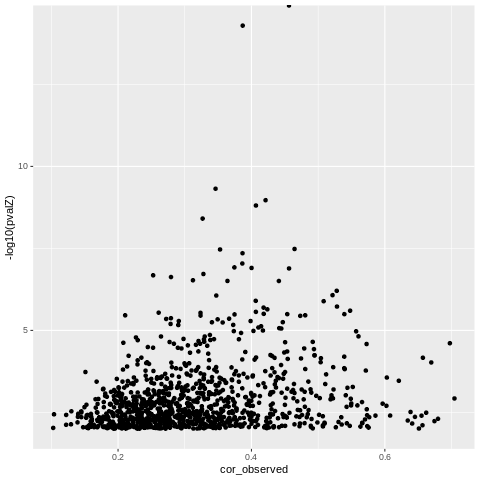

In [113]:
%%R
library(ggplot2)
ggplot(signif_cor_observed, aes(cor_observed, -log10(pvalZ))) +
geom_point()

How can you assess that your predicted associations make sense? Some ideas:
- Use positive control: e.g. we expect that peaks in the proximity of Transcription Start Sites should be more frequently linked to gene expression.
- Can you define a set of "negative control pairs" where you _don't_ expect to see association?
- Are peaks associated to genes enriched in Transcription Factor motifs? Have a look at [muon helper functions](https://muon.readthedocs.io/en/latest/api/generated/muon.atac.tl.scan_sequences.html?highlight=motif) and [motifmatchr](http://bioconductor.org/packages/release/bioc/html/motifmatchr.html).

In [114]:
%%R -o signif_cor_observed
head(signif_cor_observed)

                    peak            gene cor_observed       pvalZ
1                   <NA>            <NA>           NA          NA
2                   <NA>            <NA>           NA          NA
3                   <NA>            <NA>           NA          NA
4 chr1-11051717-11052217 ENSG00000116649    0.2468047 0.001814225
5 chr1-11060551-11061051 ENSG00000116649    0.5429873 0.006828929
6 chr1-11061653-11062153 ENSG00000116649    0.2111255 0.004322403


In [117]:
signif_cor_observed = signif_cor_observed.dropna()

### Visualize pairs on embeddings

In [196]:
# [mdata["rna"].var_names[mdata["rna"].var["gene_id"] == x for x in signif_cor_observed.gene]
mdata["rna"].var["gene_id_clean"] = [x[0] for x in mdata["rna"].var["gene_id"].str.split('.')]
signif_cor_observed['gene_name'] = [mdata["rna"].var_names[mdata["rna"].var["gene_id_clean"] == x][0] for x in signif_cor_observed.gene]

In [204]:
mdata['atac'].var
mdata['atac'].var['peak_id'] = mdata['atac'].var.seqnames.astype('str') + "-" + mdata['atac'].var.start.astype('str') + "-" + mdata['atac'].var.end.astype('str')    

mdata['atac'].var_names = mdata['atac'].var["peak_id"]

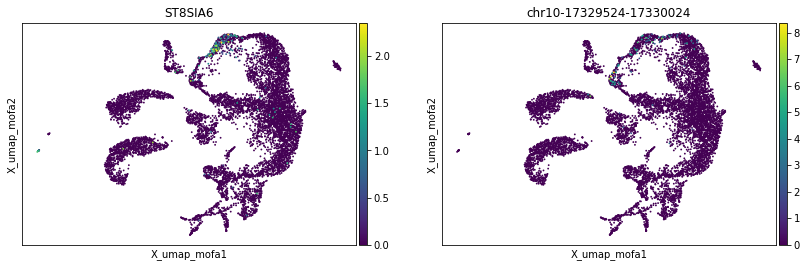

None


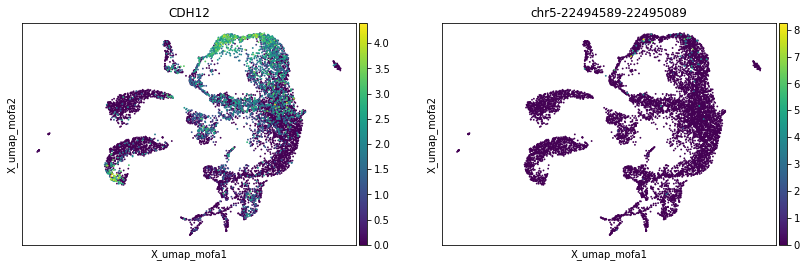

None


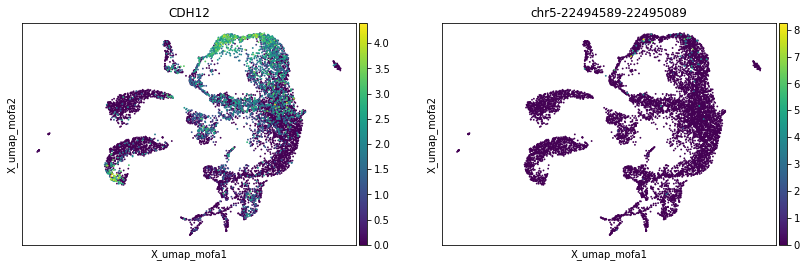

None


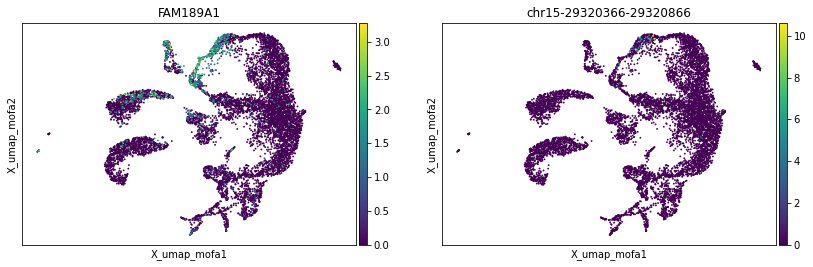

None


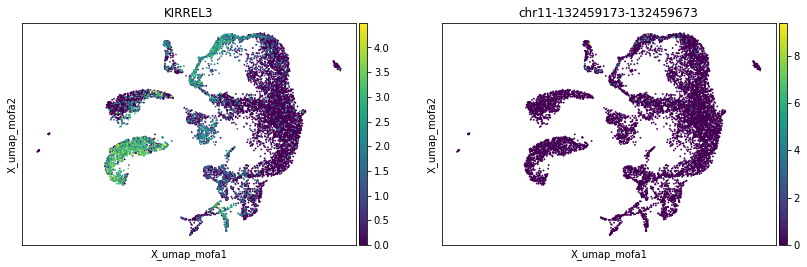

None


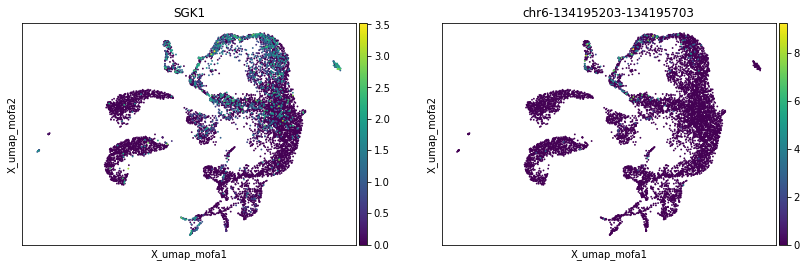

None


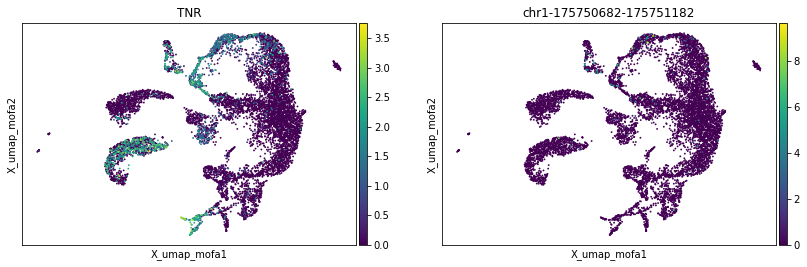

None


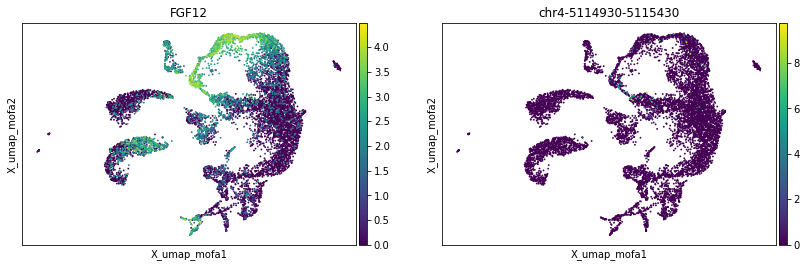

None


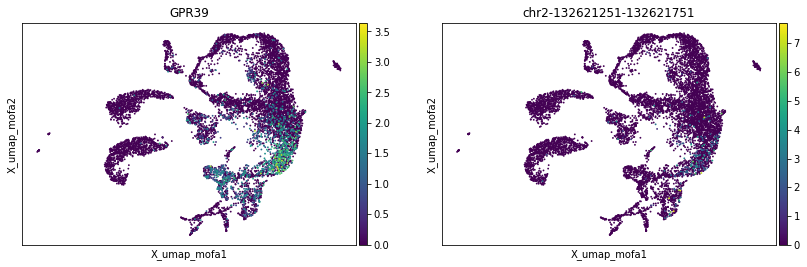

None


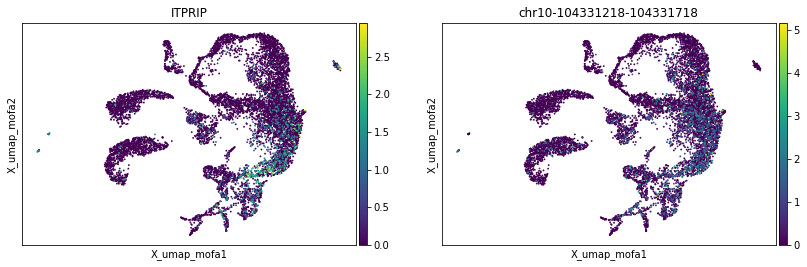

None


In [219]:
def plot_p2g_pair(mdata, g, p):
    mdata.obs['g_expression'] = mdata['rna'][:,g].X.toarray().ravel()
    mdata.obs['p_accessibility'] = mdata['atac'][:,p].X.toarray().ravel()
    sc.pl.embedding(mdata, "X_umap_mofa", color=['g_expression', 'p_accessibility'], title=(g,p))

smp_ixs = np.random.choice(signif_cor_observed[signif_cor_observed.cor_observed > 0.4].index, 10) 
for i in smp_ixs:
    print(plot_p2g_pair(mdata, signif_cor_observed['gene_name'][i], signif_cor_observed['peak'][i]))


### Distance to TSS

In [159]:
%%R -i signif_cor_observed
transcript_coords <- ensembldb::transcripts(EnsDb.Hsapiens.v86, filter = ~ gene_biotype == "protein_coding")
seqlevelsStyle(transcript_coords) <- 'UCSC'
transcript_coords <- keepStandardChromosomes(transcript_coords, pruning.mode = 'coarse')
tss_coords <- resize(unlist(range(split(transcript_coords, ~ tx_id))), width=1)

signif_peaks_gr <- StringToGRanges(signif_cor_observed[,'peak'], sep=c("-",'-'))
tss_distance <- distanceToNearest(signif_peaks_gr, tss_coords)
signif_cor_observed$tss_distance_signif <- tss_distance@elementMetadata$distance

In [160]:
%%R -o signif_cor_observed
nonsignif_peaks_gr <- StringToGRanges(sample(pairnames[,'peak'], length(signif_peaks_gr)), sep=c("-",'-'))
tss_distance <- distanceToNearest(nonsignif_peaks_gr, tss_coords)
signif_cor_observed$tss_distance_rand <- tss_distance@elementMetadata$distance

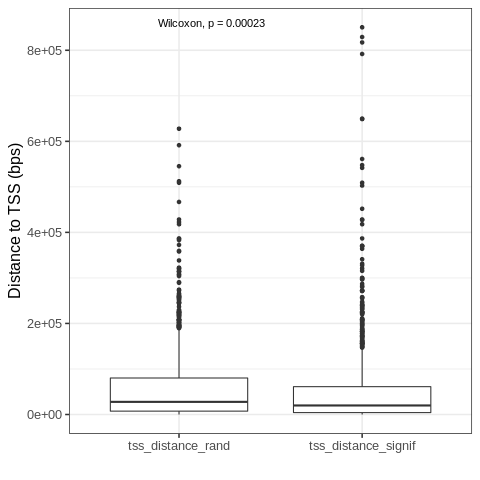

In [164]:
%%R
signif_cor_observed %>%
    pivot_longer(c("tss_distance_signif", "tss_distance_rand")) %>%
    ggplot(aes(name, value)) +
    geom_boxplot() +
    ggpubr::stat_compare_means() +
    theme_bw(base_size=16) +
    ylab("Distance to TSS (bps)") + xlab("")

---